# Chapter 06 - Shape optimization

In [15]:
from math import sqrt
import torch
import matplotlib.pyplot as plt
from simple_truss import Truss
from utils import plot_contours

plt.rcParams["text.usetex"] = True
torch.set_default_dtype(torch.double)

In [16]:
def box_constrained_decent(
    func, x_init, x_lower, x_upper, eta=0.1, max_iter=100, tol=1E-10, **extra_args
):
    x = x_init.clone().requires_grad_()
    for _ in range(max_iter):
        x_old = x.clone()
        grad = torch.autograd.grad(func(x, **extra_args).sum(), x)[0]
        x = x - eta * grad
        x = torch.max(torch.min(x, x_upper), x_lower)
        if torch.norm(x-x_old) < tol:
            return x
    return x

In [17]:
def MMA(func, x_k, L_k, U_k):
    x_lin = x_k.clone().requires_grad_()
    grads = torch.autograd.grad(func(x_lin), x_lin)[0]
    neg_grad = grads < 0.0
    pos_grad = ~neg_grad
    f_k = func(x_k)

    def approximation(x):
        p = torch.zeros_like(grads)
        p[pos_grad] = (U_k[pos_grad] - x_k[pos_grad]) ** 2 * grads[pos_grad]
        q = torch.zeros_like(grads)
        q[neg_grad] = -((x_k[neg_grad] - L_k[neg_grad]) ** 2) * grads[neg_grad]
        return (
            f_k
            - torch.sum(p / (U_k - x_k) + q / (x_k - L_k))
            + torch.sum(p / (U_k - x) + q / (x - L_k))
        )

    return approximation, grads

## Example 31 - Three bar truss shape optimization

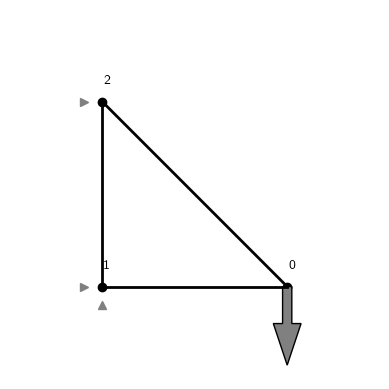

In [18]:
# Structure
nodes = torch.tensor([[1.0, 0.0], [0.0, 0.0], [0.0, 1.0]])
elements = [[0, 1], [0, 2], [1, 2]]

# Forces
forces = torch.zeros_like(nodes)
forces[0, 1] = -0.2

# Constraints
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[1, 0] = True
constraints[1, 1] = True
constraints[2, 0] = True

# Areas
areas = torch.ones((len(elements)))

# Truss
three_bar_truss = Truss(nodes.clone(), elements, forces, constraints, areas, E=10.0)
three_bar_truss.plot()

In [19]:
mask = torch.zeros_like(nodes, dtype=bool)
mask[0, 1] = True
mask[2, 1] = True

# Limits on design variables
x_0 = nodes[mask].ravel()
x_min = x_0 - 0.5
x_max = x_0 + 0.5

# Compute volume restriction
l = three_bar_truss.element_lengths()
V0 = torch.inner(areas, l)

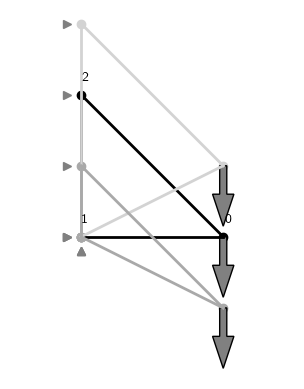

In [20]:
three_bar_truss.plot()
# Modify masked nodes to maximum values
three_bar_truss.nodes[mask] = x_max
three_bar_truss.plot(default_color="lightgray", node_labels=False)
# Modify masked nodes to minimum values
three_bar_truss.nodes[mask] = x_min
three_bar_truss.plot(default_color="darkgray", node_labels=False)
plt.axis([-0.5, 1.5, -1.0, 1.6])
plt.savefig("../figures/three_bar_truss_shapes.pdf", transparent=True, bbox_inches="tight")
plt.show()

# Reset nodes to initial values
three_bar_truss.nodes = nodes.clone()

In [21]:
def f(xx):
    # Compute compliance
    three_bar_truss.nodes[mask] = xx.reshape(three_bar_truss.nodes[mask].shape)
    u_k, f_k, _ = three_bar_truss.solve()
    return torch.inner(f_k.ravel(), u_k.ravel())


def g(xx):
    # Compute constraint
    three_bar_truss.nodes[mask] = xx.reshape(three_bar_truss.nodes[mask].shape)
    return torch.inner(three_bar_truss.areas, three_bar_truss.element_lengths()) - V0


# Compute initial asymptotes
s = 0.7
x_k = x_0
L_k = x_k - s * (x_max - x_min)
U_k = x_k + s * (x_max - x_min)

# Compute the current approximation function:
f_tilde, _ = MMA(f, x_k, L_k, U_k)
g_tilde, _ = MMA(g, x_k, L_k, U_k)

In [22]:
# Perform function evaluations at all points of the domain
buffer = 0.05
x_1 = torch.linspace(x_min[0] - buffer, x_max[0] + buffer, 50)
x_2 = torch.linspace(x_min[1] - buffer, x_max[1] + buffer, 50)
x = torch.stack(torch.meshgrid(x_1, x_2, indexing="xy"), dim=2)
f_eval = torch.zeros((len(x_1) * len(x_2)))
f_tilde_eval = torch.zeros((len(x_1) * len(x_2)))
for i, xx in enumerate(x.reshape((-1, 2))):
    f_eval[i] = f(xx)
    f_tilde_eval[i] = f_tilde(xx)

g_eval = torch.zeros((len(x_2), len(x_1)))
g_tilde_eval = torch.zeros((len(x_2), len(x_1)))
for i in range(x.shape[0]):
    for j in range(x.shape[1]):
        g_eval[i, j] = g(x[i, j])
        g_tilde_eval[i, j] = g_tilde(x[i, j])

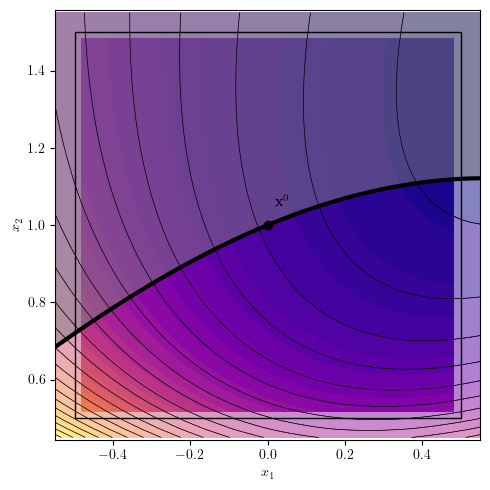

In [23]:
# Plot original problem
plot_contours(
    x[..., 0],
    x[..., 1],
    f_eval.reshape(x.shape[0], x.shape[1]),
    box=[x_min, x_max],
    figsize=(5, 5),
)
plt.contour(x_1, x_2, g_eval.detach(), [0.0], colors="k", linewidths=3)
plt.contourf(x_1, x_2, g_eval.detach(), [0, 10], colors="gray", alpha=0.5)
plt.plot([x_0[0]], [x_0[1]], "o", color="black")
plt.annotate("$\mathbf{x}^0$", (0.02, 1.05), color="black")
plt.axis("equal")
plt.savefig("../figures/three_bar_truss_shape_original.pdf", transparent=True, bbox_inches="tight")

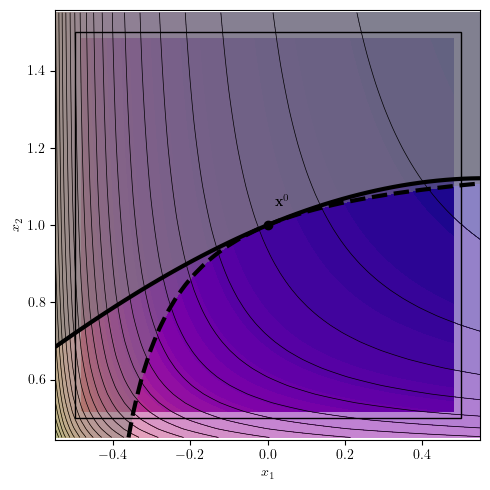

In [24]:
# Plot approximated problem
plot_contours(
    x[..., 0],
    x[..., 1],
    f_tilde_eval.reshape(x.shape[0], x.shape[1]),
    box=[x_min, x_max],
    figsize=(5, 5),
),
plt.contour(x_1, x_2, g_eval.detach(), [0.0], colors="k", linewidths=3)
plt.contourf(x_1, x_2, g_eval.detach(), [0, 10], colors="gray", alpha=0.5)
plt.contour(
    x_1, x_2, g_tilde_eval.detach(), [0.0], colors="k", linewidths=3, linestyles="--"
)
plt.contourf(x_1, x_2, g_tilde_eval.detach(), [0, 10], colors="gray", alpha=0.5)
plt.plot([x_0[0]], [x_0[1]], "o", color="black")
plt.annotate("$\mathbf{x}^0$", (0.02, 1.05), color="black")
plt.axis("equal")
plt.savefig("../figures/three_bar_truss_shape_mma.pdf", transparent=True, bbox_inches="tight")

## Optimization

In [25]:
def optimize(truss, x_0, x_min, x_max, V_0, mask, iter=3):
    L = []
    U = []
    s = 0.7

    x = [x_0]

    # Define the initial value, lower bound, and upper bound of "mu"
    mu_0 = torch.tensor([0.01])
    mu_lower = torch.tensor([1E-10])
    mu_upper = torch.tensor([100.0])

    def f(xx):
        # Solve the truss problem at point x_k
        truss.nodes[mask] = xx.reshape(truss.nodes[mask].shape)
        u_k, f_k, _ = truss.solve()
        return torch.inner(f_k.ravel(), u_k.ravel())

    def g(xx):
        truss.nodes[mask] = xx.reshape(truss.nodes[mask].shape)
        return torch.inner(truss.areas, truss.element_lengths()) - V_0

    # Iterate solutions
    for k in range(iter):
        # Update asymptotes with heuristic procedure
        if k > 1:
            L_k = torch.zeros_like(L[k - 1])
            U_k = torch.zeros_like(U[k - 1])
            for j in range(len(L_k)):
                if (x[k][j] - x[k - 1][j]) * (x[k - 1][j] - x[k - 2][j]) < 0.0:
                    L_k[j] = x[k][j] - s * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + s * (U[k - 1][j] - x[k - 1][j])
                else:
                    L_k[j] = x[k][j] - 1.0 / sqrt(s) * (x[k - 1][j] - L[k - 1][j])
                    U_k[j] = x[k][j] + 1.0 / sqrt(s) * (U[k - 1][j] - x[k - 1][j])
            L.append(L_k)
            U.append(U_k)
        else:
            L.append(x[k] - s * (x_max - x_min))
            U.append(x[k] + s * (x_max - x_min))

        # Compute lower move limit in this step
        x_min_k = torch.maximum(x_min, 0.9 * L[k] + 0.1 * x[k])
        x_max_k = torch.minimum(x_max, 0.9 * U[k] + 0.1 * x[k])

        # Compute the current approximation function:
        f_tilde, f_grad = MMA(f, x[k], L[k], U[k])
        g_tilde, g_grad = MMA(g, x[k], L[k], U[k])

        # Define the Lagrangian
        def lagrangian(xx, mu):
            return f_tilde(xx) + mu * g_tilde(xx)

        # Define a_star by minimizing the Lagrangian w. r. t. a analytically
        def x_star(mu):
            x_hat = torch.zeros_like(f_grad)
            # Case 1
            cond1 = (f_grad > 0.0) & (g_grad > 0.0)
            x_hat[cond1] = x_min[cond1]
            # Case 2
            cond2 = (f_grad < 0.0) & (g_grad < 0.0)
            x_hat[cond2] = x_max[cond2]
            # Case 3
            cond3 = (f_grad > 0.0) & (g_grad < 0.0)
            roots = torch.sqrt(
                (-mu * g_grad[cond3] * (x[k][cond3] - L[k][cond3]) ** 2)
                / (U[k][cond3] - x[k][cond3]) ** 2
                / f_grad[cond3]
            )
            x_hat[cond3] = (U[k][cond3] * roots + L[k][cond3]) / (1 + roots)
            # Case 4
            cond4 = (f_grad < 0.0) & (g_grad > 0.0)
            roots = torch.sqrt(
                (-mu * g_grad[cond4] * (U[k][cond4] - x[k][cond4]) ** 2)
                / (x[k][cond4] - L[k][cond4]) ** 2
                / f_grad[cond4]
            )
            x_hat[cond4] = (U[k][cond4] + L[k][cond4] * roots) / (1 + roots)
            return torch.max(torch.min(x_hat, x_max_k), x_min_k)


        # Define (-1 times) the dual function
        def dual_function(mu):
            return -lagrangian(x_star(mu), mu)

        # Compute the maximum of the dual function
        mu_star = box_constrained_decent(
            dual_function, mu_0, mu_lower, mu_upper, eta=0.001
        )

        # # Plot the dual function (just for debuging)
        # mu = torch.linspace(0.0, 0.1, 50)
        # dual = [-dual_function(m) for m in mu]
        # with torch.no_grad():
        #     plt.plot(mu, dual)
        #     plt.axvline(mu_star.item(), color="black")
        #     plt.title(f"Dual function in iteration {k}")
        #     plt.show()

        # Compute current optimal point with dual solution
        x.append(x_star(mu_star).detach())

    return x

## Optimization of the three bar truss

In [26]:
x_opt = optimize(three_bar_truss, x_0, x_min, x_max, V0, mask)

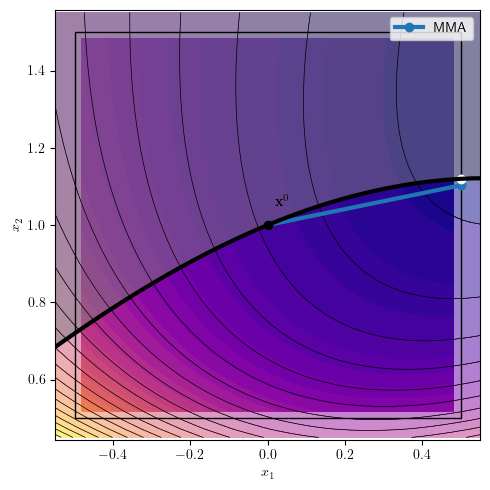

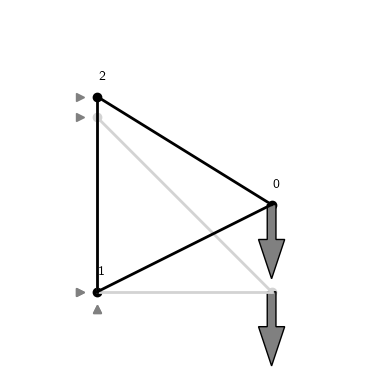

In [27]:
# Plot original problem
plot_contours(
    x[..., 0],
    x[..., 1],
    f_eval.reshape(x.shape[0], x.shape[1]),
    box=[x_min, x_max],
    figsize=(5, 5),
    paths={"MMA": x_opt},
    opti=[x_opt[-1][0], x_opt[-1][1]],
)
plt.contour(x_1, x_2, g_eval.detach(), [0.0], colors="k", linewidths=3)
plt.contourf(x_1, x_2, g_eval.detach(), [0, 10], colors="gray", alpha=0.5)
plt.plot([x_0[0]], [x_0[1]], "o", color="black")
plt.annotate("$\mathbf{x}^0$", (0.02, 1.05), color="black")
plt.axis("equal")
plt.savefig("../figures/three_bar_truss_shape_optimization.pdf", transparent=True, bbox_inches="tight")
plt.show()

# Modify masked nodes to maximum values
three_bar_truss.nodes[mask] = x_0
three_bar_truss.plot(default_color="lightgray", node_labels=False)
three_bar_truss.nodes[mask] = x_opt[-1]
three_bar_truss.plot()
plt.savefig("../figures/three_bar_truss_shape_optimized.pdf", transparent=True, bbox_inches="tight")

## Bridge

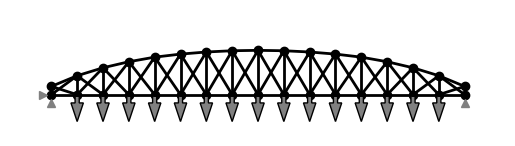

In [28]:
# Dimensions
A = 17
B = 2

# Nodes
n1 = torch.linspace(0.0, 5.0, A)
n2 = torch.linspace(0.0, 0.5, B)
n1, n2 = torch.stack(torch.meshgrid(n1, n2, indexing="xy"))
nodes = torch.stack([n1.ravel(), n2.ravel()], dim=1)

# Elements
elements = [] 
for i in range(A - 1):
    for j in range(B):
        elements.append([i + j * A, i + 1 + j * A])
for i in range(A):
    for j in range(B - 1):
        elements.append([i  + j * A, i  + A + j * A])
for i in range(A - 1):
    for j in range(B - 1):
        elements.append([i + j * A, i + 1 + A + j * A])
        elements.append([i + 1 + j * A, i + A + j * A])

# Forces at bottom edge
forces = torch.zeros_like(nodes)
forces[1:A-1, 1] = -0.1

# Constraints by the supports
constraints = torch.zeros_like(nodes, dtype=bool)
constraints[0, 0] = True
constraints[0, 1] = True
constraints[A-1, 1] = True  

# Areas
areas = torch.ones((len(elements)))

# Truss
bridge = Truss(nodes.clone(), elements, forces, constraints, areas, E=500.0)

# Mask for design variables.
mask = torch.zeros_like(nodes, dtype=bool)
mask[A:2*A, 1] = True

# Limits on design variables
x_0 = nodes[mask].ravel()
x_min = x_0 - 0.4
x_max = x_0 + 0.5

# Compute current volume
l = bridge.element_lengths()
V0 = torch.inner(areas, l)

# Optimize
x_opt = optimize(bridge, x_0, x_min, x_max, V0, mask, iter=50)

# Visualize
bridge.nodes[mask] = x_opt[-1].reshape(bridge.nodes[mask].shape)
bridge.plot(node_labels=False)
plt.savefig("../figures/bridge_shape_optimized.pdf", transparent=True, bbox_inches="tight")